In [1]:
import os
import json
import hoomd
import codecs

import numpy as np

import polychrom_hoomd.build as build
import polychrom_hoomd.forces as forces
import polychrom_hoomd.render as render

In [2]:
# Initialise HooMD
hoomd.context.initialize("")
hoomd.option.set_notice_level(1)

HOOMD-blue 2.7.0 DOUBLE HPMC_MIXED TBB SSE SSE2 SSE3 
Compiled: 10/02/2019
Copyright (c) 2009-2019 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, C D Lorenz, and A Travesset. "General purpose molecular dynamics
  simulations fully implemented on graphics processing units", Journal of
  Computational Physics 227 (2008) 5342--5359
* J Glaser, T D Nguyen, J A Anderson, P Liu, F Spiga, J A Millan, D C Morse, and
  S C Glotzer. "Strong scaling of general-purpose molecular dynamics simulations
  on GPUs", Computer Physics Communications 192 (2015) 97--107
-----
HOOMD-blue is running on the CPU


In [3]:
# Generate RNG seed
rng_seed = os.urandom(4)
rng_seed = int(codecs.encode(rng_seed, 'hex'), 16)

print("Using entropy-harvested random seed: %d" % rng_seed)

Using entropy-harvested random seed: 3901781252


In [4]:
# Simulate a single chromosome comprised of 10 1500-monomer-long repeat units with number density 0.2
n_beads = 1500
n_repeats = 10
density = 0.2

In [5]:
# Read input force parameters
with open("force_dict_homopolymer.json", 'r') as dict_file:
    force_dict = json.load(dict_file)

print(json.dumps(force_dict, indent=4, sort_keys=True))

{
    "Angular forces": {
        "Bend": {
            "Stiffness": 1.5,
            "Type": "KG"
        }
    },
    "Bonded forces": {
        "Backbone": {
            "Rest length": 1.0,
            "Type": "Harmonic",
            "Wiggle distance": 0.1
        }
    },
    "External forces": {
        "Confinement": {
            "Type": "Spherical"
        }
    },
    "Non-bonded forces": {
        "Repulsion": {
            "Cutoff": 1.0,
            "Matrix": {
                "A": {
                    "A": 10.0,
                    "B": 10.0
                },
                "B": {
                    "A": 10.0,
                    "B": 10.0
                }
            },
            "Type": "DPD"
        }
    }
}


In [6]:
# Setup initial simulation snapshot in spherical confinement
snap = build.set_init_snapshot(n_beads, n_repeats, density, mode_init="cubic", **force_dict)

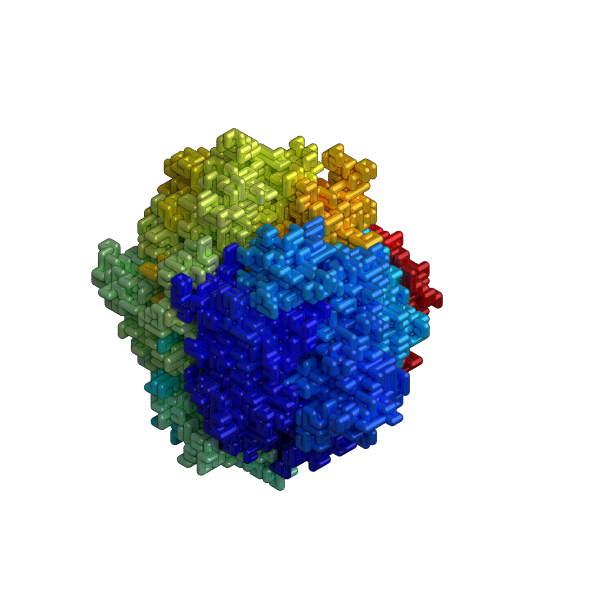

In [7]:
# Visualize starting conformation using the Fresnel backend
render.fresnel(snap, pathtrace=True, cmap="jet")

In [8]:
# Setup HooMD simulation object
system = hoomd.init.read_snapshot(snap)

In [9]:
# Setup neighbor list
nl = hoomd.md.nlist.cell()

In [10]:
# Set chromosome excluded volume
excluded_force = forces.set_excluded_volume(nl, mode_integ="Langevin", **force_dict)

In [11]:
# Set bonded potentials
bond_force = forces.set_bonds(**force_dict)
angle_force = forces.set_angles(**force_dict)

In [12]:
# Set spherical confining wall
R = (3*n_beads*n_repeats / (4*np.pi*density))**(1/3.)
confinement_force = forces.set_confinement(R, **force_dict)

In [13]:
# HooMD to openMM time conversion factor
t_conv = (1.67377*10**-27/(1.380649*10**-23*300))**0.5

In [14]:
# Initialize integrators and Langevin thermostat
hoomd.md.integrate.mode_standard(dt=7*t_conv)
langevin = hoomd.md.integrate.langevin(group=hoomd.group.all(), kT=1.0, seed=rng_seed)

In [15]:
# Run
hoomd.run(2e4)

** starting run **
Time 00:00:10 | Step 2132 / 20000 | TPS 213.151 | ETA 00:01:23
Time 00:00:20 | Step 4458 / 20000 | TPS 232.574 | ETA 00:01:06
Time 00:00:30 | Step 6844 / 20000 | TPS 238.575 | ETA 00:00:55
Time 00:00:40 | Step 9256 / 20000 | TPS 241.165 | ETA 00:00:44
Time 00:00:50 | Step 11701 / 20000 | TPS 244.463 | ETA 00:00:33
Time 00:01:00 | Step 14176 / 20000 | TPS 247.458 | ETA 00:00:23
Time 00:01:10 | Step 16648 / 20000 | TPS 247.161 | ETA 00:00:13
Time 00:01:20 | Step 19157 / 20000 | TPS 250.85 | ETA 00:00:03
Time 00:01:23 | Step 20000 / 20000 | TPS 251.216 | ETA 00:00:00
Average TPS: 239.897
---------
-- Neighborlist stats:
1892 normal updates / 200 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 9 / n_neigh_avg: 1.10993
shortest rebuild period: 8
-- Cell list stats:
Dimension: 74, 74, 74
n_min    : 0 / n_max: 6 / n_avg: 0.0370166
** run complete **


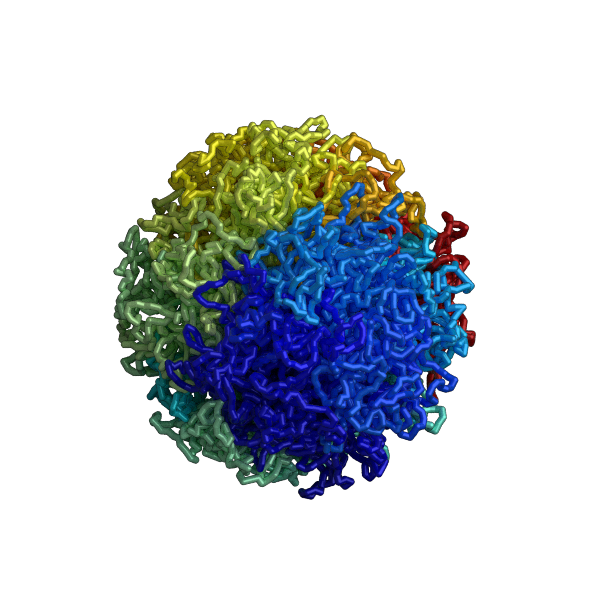

In [16]:
# Visualize new conformation
snap = system.take_snapshot(all=True)
render.fresnel(snap, pathtrace=True, cmap="jet")

In [17]:
# Set up domains by assigning monomers to a type 0 (A) or 1 (B)
domains = np.zeros(n_beads)
domains[n_beads//3:2*n_beads//3] = 1

snap.particles.typeid[:] = np.tile(domains, n_repeats)

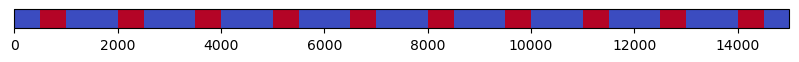

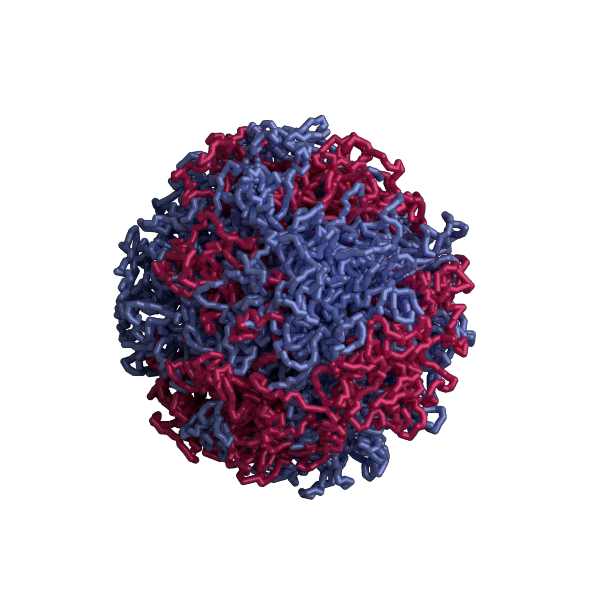

In [18]:
# Visualize domains in 1D and 3D
render.domain_viewer(snap, cmap="coolwarm")
render.fresnel(snap, pathtrace=True, show_compartments=True, cmap="coolwarm")

In [19]:
# Load updated snapshot
system.restore_snapshot(snap)

In [20]:
# Define a pseudo-square-well attractive force acting on B-type monomers
force_dict["Non-bonded forces"]["Attraction"] = {
    "Cutoff": 1.5,
    "Matrix": {
        "A": {
            "A": 0,
            "B": 0
        },
        "B": {
            "A": 0,
            "B": 0.2
        }
    },
    "Type": "PSW"
}

In [21]:
# Set corresponding type-specific force
specific_force = forces.set_specific_attraction(nl, **force_dict)

In [22]:
# Disable Langevin thermostat
excluded_force.disable()
langevin.disable()

In [23]:
# Set DPD forces/integrator
excluded_force = forces.set_excluded_volume(nl, mode_integ="DPD", seed=rng_seed, **force_dict)
nve = hoomd.md.integrate.nve(group=hoomd.group.all())

-----
You are using DPD. Please cite the following:
* C L Phillips, J A Anderson, and S C Glotzer. "Pseudo-random number generation
  for Brownian Dynamics and Dissipative Particle Dynamics simulations on GPU
  devices", Journal of Computational Physics 230 (2011) 7191--7201
-----


In [ ]:
# Run
hoomd.run(2e4)

** starting run **
Time 00:02:34 | Step 22148 / 40000 | TPS 214.753 | ETA 00:01:23
Time 00:02:44 | Step 24062 / 40000 | TPS 191.216 | ETA 00:01:23
Time 00:02:54 | Step 25891 / 40000 | TPS 182.897 | ETA 00:01:17
Time 00:03:04 | Step 27729 / 40000 | TPS 183.799 | ETA 00:01:06
Time 00:03:14 | Step 29568 / 40000 | TPS 183.774 | ETA 00:00:56


In [ ]:
# Visualize new conformation
snap = system.take_snapshot(all=True)
render.fresnel(snap, pathtrace=True, show_compartments=True, cmap="coolwarm")